In [ ]:
import torch
from torch import nn
from torchvision.ops import StochasticDepth
import math

In [ ]:
# stochastic depth 에 대해
class test_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.stochastic_depth = StochasticDepth(0.3, "row") # 0.3이 죽일 확률 # "row"는 data 마다 다른 depth를 가지게 함!
        self.residual = nn.Conv2d(1,1,1, bias=False)
        
    def forward(self,x):
        residual = self.residual(x)
        residual = self.stochastic_depth(residual)
        return x + residual

model=test_model()
x=torch.ones(2,1,2,2)
model.train()
print(model(x)) # 훈련 때는 1/(1-p) 를 곱한다
w=model.residual.weight.item()
print(torch.round(x + x * w/(1-0.3) ,decimals=4))

model.eval()
print(model(x))
print(torch.round(x + x * w        ,decimals=4)) # 테스트는 무시하지 않고 통과시킨다.
# stochastic depth는 드랍아웃을 node가 아닌 residual에 적용했다고 생각할 수 있다. (residual=0 이면 그냥 통과인거니까)
# stochastic depth 논문에서는 훈련때는 랜덤하게 skip하고 테스트 때는 다 통과하되 1-p를 곱하는 것으로 설명 되어있다.
# 하지만 토치 구현에서는 반대로 train 때 1/(1-p) 를 곱하고 테스트 때는 그냥 통과하는 것으로 구현!
# 드랍아웃도 이처럼 논문과 달리 1/(1-p) 로 키워놓고 테스트 때는 그대로 나오게끔 구현되어있음

tensor([[[[1.0000, 1.0000],
          [1.0000, 1.0000]]],


        [[[1.7406, 1.7406],
          [1.7406, 1.7406]]]], grad_fn=<AddBackward0>)
tensor([[[[1.7406, 1.7406],
          [1.7406, 1.7406]]],


        [[[1.7406, 1.7406],
          [1.7406, 1.7406]]]])
tensor([[[[1.5184, 1.5184],
          [1.5184, 1.5184]]],


        [[[1.5184, 1.5184],
          [1.5184, 1.5184]]]], grad_fn=<AddBackward0>)
tensor([[[[1.5184, 1.5184],
          [1.5184, 1.5184]]],


        [[[1.5184, 1.5184],
          [1.5184, 1.5184]]]])


In [ ]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    # 쉽게 말해, 이 함수는 가까운 8의 배수를 찾아줌

    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # divisor / 2 는 반올림을 위해 (너무 작아지지 않게)
    # case 1) v=10, divisor = 8 이면  10+4 // 8 * 8 = 8 근데 10 => 8 은 10% 이상 빠지는 거니까 8+8 = 16 으로 조정됨
    # case 2) v=39, divisor = 8 이면 39+4 // 8 * 8 = 40 => 10%보다 빠지지 않았기 때문에 40이 출력됨!

    if new_v < 0.9 * v: # 10% 보다 더 빠지지 않게 조정
        new_v += divisor
        
    return new_v

class SEBlock(nn.Module):
    def __init__(self, in_channels, squeeze_channels): # efficientNet 에서도 reduction ratio r=4인 것 같다. (논문에는 딱히 명시되어 있진 않음)
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(nn.Linear(in_channels, squeeze_channels),
                                        nn.SiLU(inplace=True), # 여기도 SiLU 사용
                                        nn.Linear(squeeze_channels, in_channels),
                                        nn.Sigmoid())

    def forward(self, x):
        SE = self.squeeze(x)
        SE = SE.reshape(x.shape[0],x.shape[1])
        SE = self.excitation(SE)
        SE = SE.unsqueeze(dim=2).unsqueeze(dim=3)
        x = x * SE
        return x

class DepSESep(nn.Module):
    def __init__(self, in_channels, squeeze_channels, out_channels, kernel_size, stride):
        super().__init__()

        self.depthwise = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size, stride = stride, padding = (kernel_size - 1) // 2, groups = in_channels, bias=False),
                                       nn.BatchNorm2d(in_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))
        
        self.seblock = SEBlock(in_channels, squeeze_channels)

        self.pointwise = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                       nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3))
                                       # no activation!!
    def forward(self, x):
        x = self.depthwise(x)
        if self.seblock is not None:
            x = self.seblock(x)
        x = self.pointwise(x)
        return x

class MBConv(nn.Module):
    def __init__(self, in_channels, exp_channels, out_channels, kernel_size, stride, sd_prob):
        super().__init__()

        self.use_skip_connect = (stride==1 and in_channels==out_channels)
        self.stochastic_depth = StochasticDepth(sd_prob, "row") # sd_prob가 죽일 확률 # "row"는 data 마다 다른 depth를 가지게 함!

        layers = []
        if in_channels != exp_channels:
            layers += [nn.Sequential(nn.Conv2d(in_channels, exp_channels, 1, bias=False),
                                     nn.BatchNorm2d(exp_channels, momentum=0.99, eps=1e-3),
                                     nn.SiLU(inplace=True))]
        squeeze_channels = in_channels // 4
        # torchvision.models를 보면 mobilnet v3 에선 squeeze_channels = expanded_channels // 4 로 https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py#L96
        # efficientNet 에선 squeeze_channels = in_channels // 4 로 해놨다.. https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py#L149
        # 그리고, squeeze_channels에 대해서 make_divisible을 mobilenet v3 에서는 하고 efficientNet에는 안해놓음
        layers += [DepSESep(exp_channels, squeeze_channels, out_channels, kernel_size, stride=stride)]

        self.residual = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_skip_connect:
            residual = self.residual(x)
            residual = self.stochastic_depth(residual)
            return x + residual
        else:
            return self.residual(x)

class EfficientNet(nn.Module):
    def __init__(self, num_classes, depth_mult, width_mult, resol_mult, drop_p, stochastic_depth_p = 0.2):
        super().__init__()

        cfgs = [#k,  t,   c,  n,  s 
                [3,  1,  16,  1,  1],
                [3,  6,  24,  2,  2],
                [5,  6,  40,  2,  2],
                [3,  6,  80,  3,  2],
                [5,  6,  112, 3,  1],
                [5,  6,  192, 4,  2],
                [3,  6,  320, 1,  1]]

        self.upsample = nn.Upsample(scale_factor=resol_mult, mode='bilinear', align_corners=False) # resolution 조절
        in_channels = _make_divisible(32 * width_mult, 8) # width 조절

        # building first layer
        self.stem_conv = nn.Sequential(nn.Conv2d(3, in_channels, 3, padding=1, stride=2, bias=False),
                                       nn.BatchNorm2d(in_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))
        
        # building inverted residual blocks
        layers = []
        num_block = 0
        N = sum([math.ceil(cfg[-2] * depth_mult) for cfg in cfgs]) # 총 깊이
        for k, t, c, n, s in cfgs:
            n = math.ceil(n * depth_mult) # 깊이 조절!
            for i in range(n):
                stride = s if i == 0 else 1
                exp_channels = _make_divisible(in_channels * t, 8)
                out_channels = _make_divisible(c * width_mult, 8)
                sd_prob = stochastic_depth_p * num_block / N # 앞에는 안뛰고 뒤로 갈수록 건너 뛸 확률을 크게
                layers += [MBConv(in_channels, exp_channels, out_channels, k, stride, sd_prob)]
                in_channels = out_channels
                num_block += 1

        self.layers = nn.Sequential(*layers)

        # building last several layers
        last_channels = _make_divisible(1280 * width_mult, 8)
        self.last_conv = nn.Sequential(nn.Conv2d(in_channels, last_channels, 1, bias=False),
                                       nn.BatchNorm2d(last_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(nn.Dropout(drop_p), # 논문에는 상세히 나와있진 않지만 토치 문서에 있어서 포함 -> 채널 축으로 특징들이 놓여있고 그것들을 이리저리 바꿔 골라가며 학습하는 의미
                                        nn.Linear(last_channels, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init_range = 1.0 / torch.sqrt(torch.tensor(m.out_features))
                nn.init.uniform_(m.weight, -init_range, init_range)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def efficientnet_b0(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.0, width_mult=1.0,  resol_mult=224/224, drop_p=0.2, **kwargs)

def efficientnet_b1(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.1, width_mult=1.0,  resol_mult=240/224, drop_p=0.2, **kwargs)

def efficientnet_b2(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.2, width_mult=1.1,  resol_mult=260/224., drop_p=0.3, **kwargs) # torchvision에는 288로 되어있는데, 260으로 알려져는 있다. 뭐가 맞는지는 모르겠다.
# https://github.com/pytorch/vision/blob/98c58158d1bc09e6fab31d3bf1af36e8d1752a89/torchvision/models/efficientnet.py#L516
def efficientnet_b3(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.4, width_mult=1.2,  resol_mult=300/224, drop_p=0.3, **kwargs)

def efficientnet_b4(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.8, width_mult=1.4,  resol_mult=380/224, drop_p=0.4, **kwargs)

def efficientnet_b5(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=2.2, width_mult=1.6,  resol_mult=456/224, drop_p=0.4, **kwargs)

def efficientnet_b6(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=2.6, width_mult=1.8,  resol_mult=528/224, drop_p=0.5, **kwargs)

def efficientnet_b7(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=3.1, width_mult=2.0,  resol_mult=600/224, drop_p=0.5, **kwargs)

In [ ]:
model = efficientnet_b0()
# print(model)
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(2,3,224,224), device='cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [2, 1000]                 --
├─Upsample: 1-1                                         [2, 3, 224, 224]          --
├─Sequential: 1-2                                       [2, 32, 112, 112]         --
│    └─Conv2d: 2-1                                      [2, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                                 [2, 32, 112, 112]         64
│    └─SiLU: 2-3                                        [2, 32, 112, 112]         --
├─Sequential: 1-3                                       [2, 320, 7, 7]            --
│    └─MBConv: 2-4                                      [2, 16, 112, 112]         --
│    │    └─Sequential: 3-1                             [2, 16, 112, 112]         1,448
│    └─MBConv: 2-5                                      [2, 24, 56, 56]           --
│    │    └─Sequential: 3-2                             

In [ ]:
x = torch.randn(2,3,224,224)
print(model(x).shape)
model.train()
print(model(x))
print(model(x)) # stochastic depth, dropout 때문에 계속 바뀜
model.eval()
print(model(x))
print(model(x)) # 고정!

torch.Size([2, 1000])
tensor([[ 0.0101,  0.4523,  0.1005,  ...,  0.0866, -0.0851, -0.1520],
        [ 0.0135,  0.2917,  0.0578,  ...,  0.0304, -0.0121, -0.2655]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0459,  0.2843,  0.0817,  ...,  0.1623, -0.1156, -0.1341],
        [ 0.0398,  0.5047,  0.1762,  ...,  0.1727, -0.0515, -0.2230]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0612,  0.1749,  0.1029,  ...,  0.0894,  0.0564, -0.0703],
        [ 0.0901,  0.1042,  0.0623,  ...,  0.0068,  0.0505, -0.0277]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0612,  0.1749,  0.1029,  ...,  0.0894,  0.0564, -0.0703],
        [ 0.0901,  0.1042,  0.0623,  ...,  0.0068,  0.0505, -0.0277]],
       grad_fn=<AddmmBackward0>)


In [ ]:
import pandas as pd
df = pd.DataFrame(index=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'], columns=['depth_mult', 'width_mult', 'resolution'])

alpha = 1.2 # depth factor: d = alpha**phi
beta = 1.1 # width factor: w = beta**phi
gamma = 1.15 # resolution factor: r = gamma**phi

phi = [0, 0.5, 1, 2, 3.5, 4.5, 5.5, 6]

for i, val in enumerate(phi):
    df.loc['B'+str(i), 'depth_mult'] = round(alpha**val, 1)
    df.loc['B'+str(i), 'width_mult'] = round(beta**val, 1)
    df.loc['B'+str(i), 'resolution'] = round(224*gamma**val)

df
# d=1.0, w=1.0, r=224
# d=1.1, w=1.0, r=240
# d=1.2, w=1.1, r=260
# d=1.4, w=1.2, r=300
# d=1.8, w=1.4, r=380
# d=2.2, w=1.6, r=456
# d=2.6, w=1.8, r=528
# d=3.1, w=2.0, r=600

,depth_mult,width_mult,resolution
B0,1.0,1.0,224
B1,1.1,1.0,240
B2,1.2,1.1,258
B3,1.4,1.2,296
B4,1.9,1.4,365
B5,2.3,1.5,420
B6,2.7,1.7,483
B7,3.0,1.8,518


torch.Size([1, 3, 15, 15])


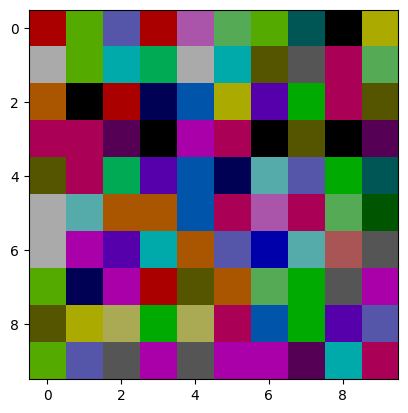

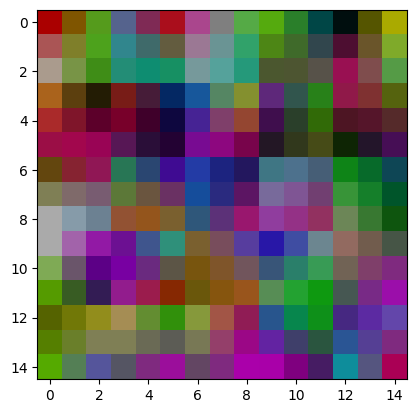

In [ ]:
import matplotlib.pyplot as plt

x=torch.randint(0,3,(1,3,10,10))/3

up=nn.Upsample(scale_factor=1.5, mode='bilinear', align_corners=False)
x_up = up(x)
print(x_up.shape)

plt.imshow(x.squeeze().permute(1,2,0))
plt.figure()
plt.imshow(x_up.squeeze().permute(1,2,0))